<a href="https://colab.research.google.com/github/Alex112525/LangGraph-notebooks/blob/main/Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install langgraph langgraph-sdk langgraph-checkpoint-sqlite langsmith langchain-community langchain-core langchain-openai tavily-python wikipedia

In [2]:
import os
from google.colab import userdata
from IPython.display import Image, display

In [3]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.retrievers import TavilySearchAPIRetriever

In [4]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


In [5]:
os.environ["AZURE_OPENAI_API_KEY"] = userdata.get('Azure_openai')
os.environ["AZURE_OPENAI_ENDPOINT"] = userdata.get('Endpoint_openai')

## Utils Funtions

In [6]:
def get_model(model:str="DASH-mini", temp:float=0.1, max_tokens:int=100):
  """Get model from Azure OpenAI"""
  model = AzureChatOpenAI(
        openai_api_version="2024-02-15-preview",
        azure_deployment=model,
        temperature=temp,
        max_tokens=max_tokens,
    )
  return model

#### Tools

In [7]:
def sum(a:float, b:float) -> float:
  """Sum a and b

  Args:
    a: first number
    b: second number"""
  return a+b

def minus(a:float, b:float) -> float:
  """Minus a and b

  Args:
    a: first number
    b: second number"""
  return a-b

def multiply(a:float, b:float) -> float:
  """Multiply a and b

  Args:
    a: first number
    b: second number"""
  return a*b

def divide(a:float, b:float) -> float:
  """Divide a and b

  Args:
    a: first number
    b: second number"""
  return a/b if b != 0 else "We cannot divide by zero"

#### Model binding

__“binding”__ tools refers to the process of connecting or associating specific tools or functions with the model so that it can use them during its operations.

In [8]:
llm = get_model()
llm_with_tools = llm.bind_tools(
    tools=[sum, minus, multiply, divide]
)

In [9]:
# System Message
sys_msg = SystemMessage(content="You are a helpful mathematical assistant, tasked with performing arithmetic in order on a set of inputs.")

def assistant(state: MessagesState):
  return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

### Build Agent and test

The agent can go back to the Assistant to perform additional operations as needed.

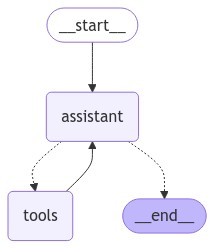

In [10]:
# Build Graph

builder = StateGraph(MessagesState)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode([sum, minus, multiply, divide]))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition) # If latest message is a tool Call -> routes Tool else routes END
builder.add_edge("tools", "assistant")

graph = builder.compile()

#View graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
messages = [HumanMessage(content="Add 3 and 5. Multiply by 6. Divide by 7")]
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

Add 3 and 5. Multiply by 6. Divide by 7
================================== Ai Message ==================================
Tool Calls:
  sum (call_rIDbMAgsHaNkVP5ff8vP1wnl)
 Call ID: call_rIDbMAgsHaNkVP5ff8vP1wnl
  Args:
    a: 3
    b: 5
================================= Tool Message =================================
Name: sum

8.0
================================== Ai Message ==================================
Tool Calls:
  multiply (call_QXkfgW9A4cvo8bIjgy7m4jHp)
 Call ID: call_QXkfgW9A4cvo8bIjgy7m4jHp
  Args:
    a: 8
    b: 6
================================= Tool Message =================================
Name: multiply

48.0
================================== Ai Message ==================================
Tool Calls:
  divide (call_sFlc8otHqJ9UdmvagmqpLwKz)
 Call ID: call_sFlc8otHqJ9UdmvagmqpLwKz
  Args:
    a: 48
    b: 7
================================= Tool Message =================================

In [12]:
messages = [HumanMessage(content="What is (223-33)/(66+2)")]
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

What is (223-33)/(66+2)
================================== Ai Message ==================================
Tool Calls:
  minus (call_TUtPgTkaE4x2GPQDhuriLGoF)
 Call ID: call_TUtPgTkaE4x2GPQDhuriLGoF
  Args:
    a: 223
    b: 33
  sum (call_pJtOX8nOrdo9HFHDXN5i3BwZ)
 Call ID: call_pJtOX8nOrdo9HFHDXN5i3BwZ
  Args:
    a: 66
    b: 2
================================= Tool Message =================================
Name: minus

190.0
================================= Tool Message =================================
Name: sum

68.0
================================== Ai Message ==================================
Tool Calls:
  divide (call_BjZwNQmBlLfMF4csiAJvZpBw)
 Call ID: call_BjZwNQmBlLfMF4csiAJvZpBw
  Args:
    a: 190
    b: 68
================================= Tool Message =================================
Name: divide

2.7941176470588234
================================== Ai Message ===========================

In [13]:
messages = [HumanMessage(content="What is (87-96)*(34-12)")]
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

What is (87-96)*(34-12)
================================== Ai Message ==================================
Tool Calls:
  minus (call_Lia5eiGcIGb9QLkNAQO5lJ0J)
 Call ID: call_Lia5eiGcIGb9QLkNAQO5lJ0J
  Args:
    a: 87
    b: 96
  minus (call_tzrzmvJ13XasZ6wusdJJhTyz)
 Call ID: call_tzrzmvJ13XasZ6wusdJJhTyz
  Args:
    a: 34
    b: 12
================================= Tool Message =================================
Name: minus

-9.0
================================= Tool Message =================================
Name: minus

22.0
================================== Ai Message ==================================
Tool Calls:
  multiply (call_OgPPEz49B7Yp5gnei2plQIFu)
 Call ID: call_OgPPEz49B7Yp5gnei2plQIFu
  Args:
    a: -9
    b: 22
================================= Tool Message =================================
Name: multiply

-198.0
================================== Ai Message =================================

In [14]:
messages = [HumanMessage(content="What is the result of (32)/(11-11)")]
messages = graph.invoke({"messages": messages})
for m in messages["messages"]:
  m.pretty_print()

================================ Human Message =================================

What is the result of (32)/(11-11)
================================== Ai Message ==================================

The expression \( (32)/(11-11) \) involves division by zero, since \( 11 - 11 = 0 \). Division by zero is undefined in mathematics. Therefore, the result of this expression is undefined.
